# **Mobile Device Usage and User Behaviour**

The objective of this project is to train an unsupervised ML model to categorize user's behaviour, with regard to the predictors, which are gender, age, etc. In the first part, we will user kCluster method to try to mimick the result of labelling in our dataset; in the second part, we will fully utilise the advantage of unsupervised machine learning to explore the patterns, especially the hidden ones in the dataset.

Let's start by importing the libraries for the project.

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# Step 1. Load and Inspect Data

In [5]:
df = pd.read_csv('/kaggle/input/mobile-device-usage-and-user-behavior-dataset/user_behavior_dataset.csv')
print(df.info())
print(df.head(10))
print(df.columns.tolist())
print(df.describe()) #
print(df.isnull().sum()) # No null


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User ID                     700 non-null    int64  
 1   Device Model                700 non-null    object 
 2   Operating System            700 non-null    object 
 3   App Usage Time (min/day)    700 non-null    int64  
 4   Screen On Time (hours/day)  700 non-null    float64
 5   Battery Drain (mAh/day)     700 non-null    int64  
 6   Number of Apps Installed    700 non-null    int64  
 7   Data Usage (MB/day)         700 non-null    int64  
 8   Age                         700 non-null    int64  
 9   Gender                      700 non-null    object 
 10  User Behavior Class         700 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 60.3+ KB
None
   User ID        Device Model Operating System  App Usage Time (min/day)  \
0        

As is shown above, there are no null values in the dataset, which means that we do not need to convert the NAs. Here follows the list of columns in the dataset:
['User ID', 'Device Model', 'Operating System', 'App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'Number of Apps Installed', 'Data Usage (MB/day)', 'Age', 'Gender', 'User Behavior Class']

Above all, user Id is not helpful for our learning process, so we need to drop the column. User Behavior Class is the dependent variable that is to be predicted, while the rest is predictors.

There are several categorical columns in the dataset, i.e. gender, Device Model and Operating System. We need to use one hot method to convert them into several boolean columns.

In [8]:
cols=df.columns.tolist()
if 'User ID' in cols:
    df=df.drop('User ID',axis=1)
#print(df.head(10))

# inspect the categories
cats=['Gender', 'Device Model', 'Operating System']
for cat in cats:
    print(df[cat].unique()) 

['Male' 'Female']
['Google Pixel 5' 'OnePlus 9' 'Xiaomi Mi 11' 'iPhone 12'
 'Samsung Galaxy S21']
['Android' 'iOS']


It seems that the categorical columns have a reasonable size of options. So it is reasonable to apply one hot method to conver them into boolean columns.

Moreover, for the other numeric columns, we can scale them for better result.

Last but not least, we want to split the data into train and test.

In [40]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

cols0=df.columns.tolist()
nums=[cols0[i] for i in range(len(cols0)) if (not cols0[i] in cats) and (not cols0[i]=='User Behavior Class')]
preproc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), nums),    # Scale numerical features
        ('cat', OneHotEncoder(), cats)     # One-hot encode categorical features
    ]
)

xcols=[cols0[i] for i in range(len(cols0)) if not cols0[i]=='User Behavior Class']
print(xcols)
ycol='User Behavior Class'

X = preproc.fit_transform(df[xcols])
new_cols = preproc.named_transformers_['cat'].get_feature_names_out(cats)
cols= nums + new_cols.tolist()

X = pd.DataFrame(X, columns=cols)
print(X.head(5))

y=df[ycol]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_test.shape,y_train.shape,X_test.shape,X_train.shape)



['Device Model', 'Operating System', 'App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'Number of Apps Installed', 'Data Usage (MB/day)', 'Age', 'Gender']
   App Usage Time (min/day)  Screen On Time (hours/day)  \
0                  0.688256                    0.367626   
1                 -0.017668                   -0.186771   
2                 -0.661471                   -0.415053   
3                 -0.181443                   -0.154160   
4                 -0.475107                   -0.317218   

   Battery Drain (mAh/day)  Number of Apps Installed  Data Usage (MB/day)  \
0                 0.423726                  0.606096             0.300405   
1                -0.237198                 -0.322441             0.022277   
2                -0.933550                 -0.693856            -0.949607   
3                 0.184279                  0.197540            -0.091787   
4                -0.193218                  0.271823             0.091

Before building and fitting models, we can perform a covariance analysis and PCA to see which features are most prominent.

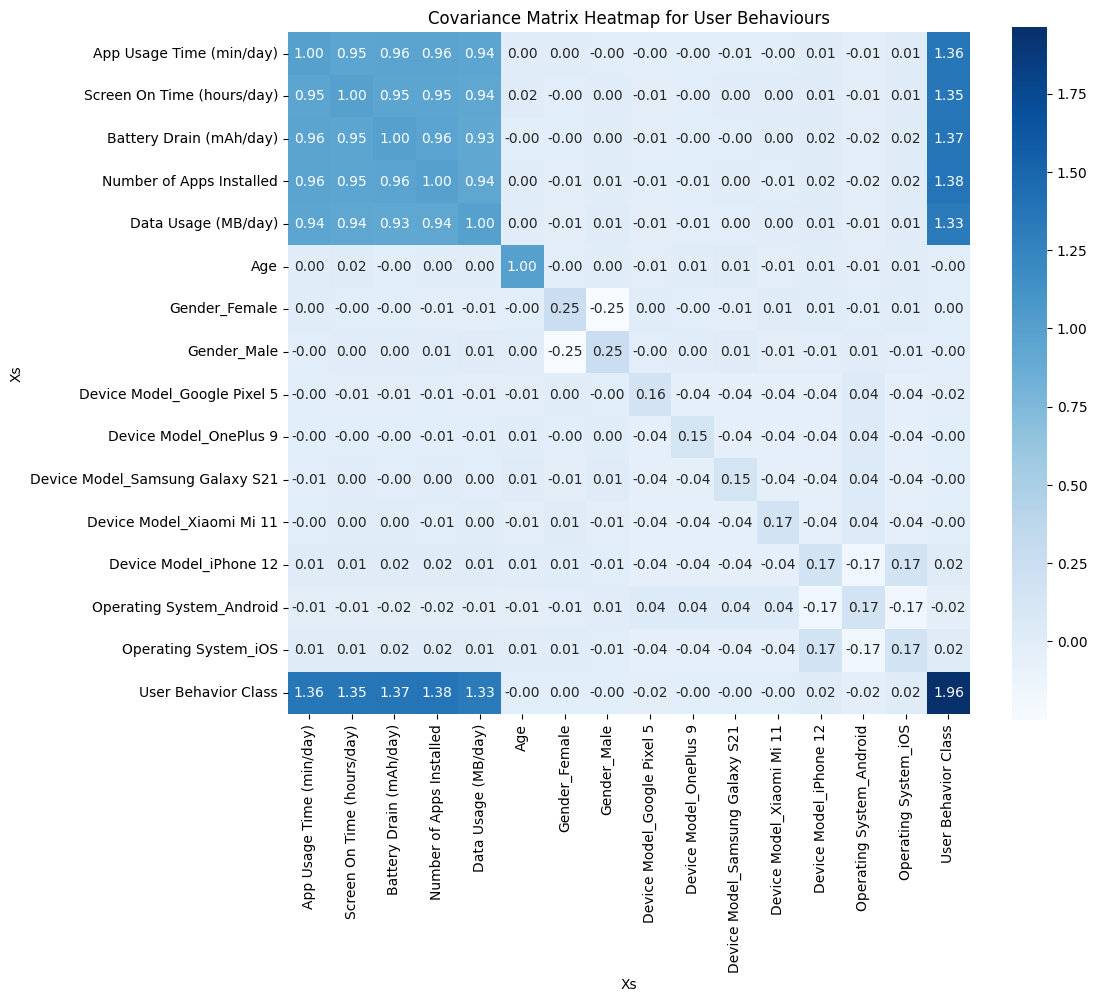

In [41]:
cov_mat=pd.concat([X,y], axis=1).cov()
#print(cov_mat)
plt.figure(figsize=(11, 9))
sns.heatmap(cov_mat, annot=True, cmap='Blues', fmt='.2f', square=True, cbar=True)
plt.title('Covariance Matrix Heatmap for User Behaviours')
plt.xlabel('Xs')
plt.ylabel('Xs')
plt.show()

From the heatmap, we can constate that user behaviour class actually is strongly related to ['App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'Number of Apps Installed', 'Data Usage (MB/day)']

Therefore, those are the columns we will retain in X.

In [43]:
cols_retained=['App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'Number of Apps Installed', 'Data Usage (MB/day)']
X_train, X_test=X_train[cols_retained], X_test[cols_retained]
print(X_train.columns,X_test.columns)

Index(['App Usage Time (min/day)', 'Screen On Time (hours/day)',
       'Battery Drain (mAh/day)', 'Number of Apps Installed',
       'Data Usage (MB/day)'],
      dtype='object') Index(['App Usage Time (min/day)', 'Screen On Time (hours/day)',
       'Battery Drain (mAh/day)', 'Number of Apps Installed',
       'Data Usage (MB/day)'],
      dtype='object')


# Step 2 Build and Fit Models

Now that the data are ready, we can build an unsupervised ML algorithm and fit the model to the train data. We can try K-Means Clustering.

In [45]:
print(y.unique())

kmeans = KMeans(n_clusters=5, n_init=10)
kmeans.fit(X_train) 
pred_train = kmeans.predict(X_train)
pred_test = kmeans.predict(X_test)

[4 3 2 5 1]


Since the labels are random, we need to loop through all the permutations to find out the right labelling. The right permutation should give the best prediction (accuracy).

In [50]:
import itertools
max_acc=0
perm_best=None

for perm in itertools.permutations(list(range(1,6,1))):
    pred_train_perm=[pred_train[perm[pred_train[i]]] for i in range(len(pred_train))]
    pred_test_perm=[pred_test[perm[pred_test[i]]] for i in range(len(pred_test))]
    acc_train=np.sum(pred_train_perm==y_train)/len(y_train)
    acc_test=np.sum(pred_test_perm==y_test)/len(y_test)
    #print("Perm:",perm,"Accuracy:",acc_train,acc_test)
    if max_acc<acc_test:
        max_acc=acc_test
        perm_best=perm

print("Best perm:",perm_best,"Best accuracy",max_acc)

Best perm: (3, 1, 2, 4, 5) Best accuracy 0.6285714285714286


# Deeper Exploration into the Data Pattern without Labels

Compared to supervised models, unsupervised models do not need to reply on the label responses, which makes it possible to further understand the patterns. For example, in our case, the number of clusters do not need to be equal to 5. We can try different values of number of clusters as well, to identify some hidden patterns. Since we will not use labels, which means that we will not use y at all. In that case, to evaluate the model, we need to use Sihouette Score or Davies-Bouldin Index.

In [52]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

for i in range(2,20,1):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(X) 
    pred_cluster= kmeans.predict(X)
    sil = silhouette_score(X, pred_cluster)
    db = davies_bouldin_score(X, pred_cluster)
    print(f'Number of Clusters, Davies-Bouldin Index and Silhouette Score: {i},{db}, {sil}')
  

Number of Clusters, Davies-Bouldin Index and Silhouette Score: 2,0.9958478941427766, 0.397394171943173
Number of Clusters, Davies-Bouldin Index and Silhouette Score: 3,1.2751132134473053, 0.2777442563597031
Number of Clusters, Davies-Bouldin Index and Silhouette Score: 4,1.4583597304178626, 0.2711683868918885
Number of Clusters, Davies-Bouldin Index and Silhouette Score: 5,1.6565661042524993, 0.2159361999313408
Number of Clusters, Davies-Bouldin Index and Silhouette Score: 6,1.684160068690492, 0.1910812683129066
Number of Clusters, Davies-Bouldin Index and Silhouette Score: 7,1.6042648523460696, 0.20201890912613038
Number of Clusters, Davies-Bouldin Index and Silhouette Score: 8,1.64994427461477, 0.1985676812411584
Number of Clusters, Davies-Bouldin Index and Silhouette Score: 9,1.6529893176171695, 0.19326325708396058
Number of Clusters, Davies-Bouldin Index and Silhouette Score: 10,1.550296897310743, 0.20009177846426252
Number of Clusters, Davies-Bouldin Index and Silhouette Score: 11

From the result, we can see that as we increase the number of clusters from 2 to 18, the DB Index increases then decreases, while the Silhouette Score decreases then increases.

A high Silhouette Score indicates that the clusters are far from each other while a positive score close to 0 means that the samples are very close to the boundaries. As for the DB index, we want it to be small as a high value indicates that the clusters are not well separated.

It seems that when i=6,8 or 9, the Silhouette score is below 0.2 and the DB Index is relatively low, which means that the data could be divided into 6,8 or 9 clusters, yielding good results. This means that we do not necessarily need to divide the user behaviours into 5 groups, but also into 6, 8 or 9 groups, which can better represent the hidden patterns and hidden modes of behaviours.

As a conclusion, the ML model is a valid model to predict user behaviours, if we divide them into 5 groups. However, it might be favorable to divide user behaviours into 6, 8 or 9 groups, as those groups might better represent the behavioral patterns.